In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/'

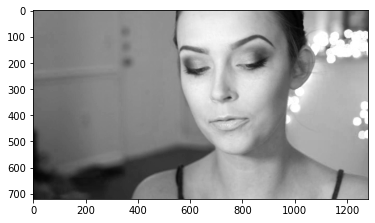

In [3]:
img = plt.imread(DATA_ROOT + '720p/image00028104.jpg')
plt.imshow(img[..., 0], cmap='gray');

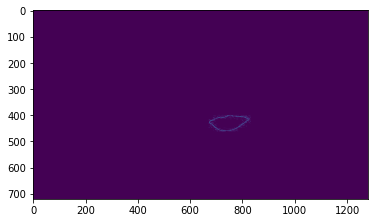

In [4]:
img = plt.imread(DATA_ROOT + 'mask/mask00028104.png')
plt.imshow(img[..., 0]);

In [5]:
cameraRGB = []
cameraSeg = []
for root, dirs, files in os.walk(DATA_ROOT):
    for name in files:
        f = os.path.join(root, name)
        if '720p' in f:
            cameraRGB.append(f)
        elif 'mask' in f:
            cameraSeg.append(f)
        else:
            break

In [6]:
len(cameraRGB), len(cameraSeg)

(28604, 28590)

In [7]:
cameraRGB = cameraRGB[:28590]

In [8]:
pd.options.display.max_colwidth = 100

df = pd.DataFrame({'720p': cameraRGB, 'mask': cameraSeg})
# Отсортируем  датафрейм по значениям
df.sort_values(by='720p',inplace=True)

df.reset_index(drop=True, inplace=True)
# Выведем первые пять значений нашего датафрейма
df.head(5)

,720p,mask
0,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/720p/image00000001.jpg,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/mask/mask00000085.png
1,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/720p/image00000002.jpg,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/mask/mask00000175.png
2,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/720p/image00000003.jpg,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/mask/mask00000057.png
3,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/720p/image00000004.jpg,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/mask/mask00000138.png
4,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/720p/image00000005.jpg,/content/drive/MyDrive/Colab Notebooks/set-lipstick-original/mask/mask00000086.png


In [9]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from torch.nn import functional as F

In [10]:
class SelfDrivingDataset(Dataset):
    def __init__(self, data, preprocessing=None):
        # Подаем наш подготовленный датафрейм
        self.data = data
        
        # Разделяем датафрейм на rgb картинки 
        self.image_arr = self.data.iloc[:,0]
        # и на сегментированные картинки
        self.label_arr = self.data.iloc[:,1]
        
        # Количество пар картинка-сегментация
        self.data_len = len(self.data.index)
        
        self.preprocessing = preprocessing

        
    def __getitem__(self, index):
        # Читаем картинку и сразу же представляем ее в виде numpy-массива 
        # размера 600х800 float-значений
        img = cv2.cvtColor(cv2.imread(self.image_arr[index]), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (256, 256))

        img = np.asarray(img).astype('float')
        
        if self.preprocessing:
            img = self.preprocessing(img)
            img = torch.as_tensor(img)
        else:
            # Нормализуем изображение в значениях [0, 1]
            img = torch.as_tensor(img) / 255.0
        img = img.permute(2,0,1)
        
        # считаем сегментированную картинку
        masks = []
        mask = cv2.cvtColor(cv2.imread(self.label_arr[index]), cv2.COLOR_BGR2RGB)
#         mask = Image.open(self.label_arr[index])
#         mask = mask.resize((256, 256))
#         mask = np.asarray(mask)
        
        for i in range(13):
            cls_mask = np.where(mask == i, 255, 0)
            cls_mask = cls_mask.astype('float')
            cls_mask = cv2.resize(cls_mask, (256, 256))

            masks.append(cls_mask[:,:,0] / 255)
            
        masks = torch.as_tensor(masks, dtype=torch.uint8)    
        
            
        return (img.float(), masks)

    def __len__(self):
        return self.data_len

<ipython-input-10-003d38a291c0>:47: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)
<ipython-input-10-003d38a291c0>:47: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([3, 256, 256]) torch.Size([13, 256, 256])


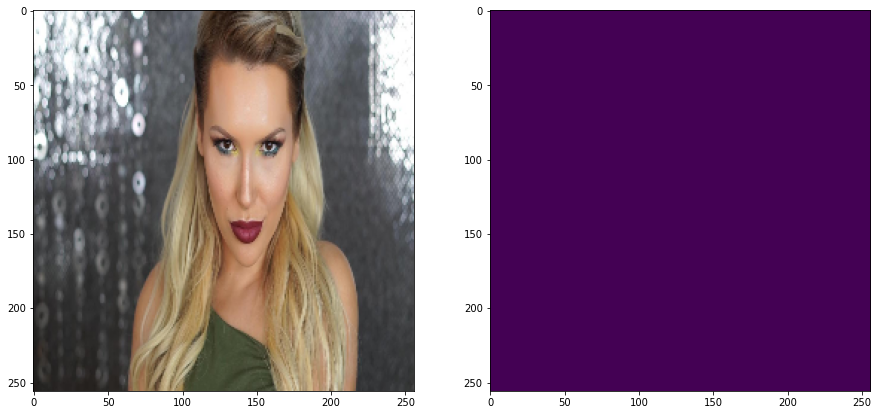

In [11]:
dataset = SelfDrivingDataset(df)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 10])
plt.show()

In [12]:
from sklearn.model_selection import train_test_split

# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.3)

# Упорядочиваем индексацию
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = SelfDrivingDataset(X_train)
test_data = SelfDrivingDataset(X_test)

In [13]:
train_data_loader = DataLoader(
    train_data,
    batch_size=8,
    shuffle=True
)
test_data_loader = DataLoader(
    test_data,
    batch_size=4,
    shuffle=False
)

<ipython-input-10-003d38a291c0>:47: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([8, 3, 256, 256]) torch.Size([8, 13, 256, 256])
tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


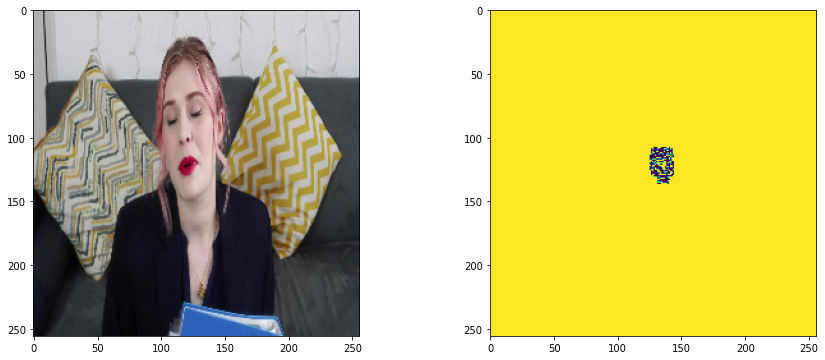

In [14]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    fig, ax = plt.subplots(1, 2, figsize=(15, 6))
    ax[0].imshow(img[0].permute(1, 2, 0))
    ax[1].imshow(target[0].permute(1, 2, 0)[..., 0])
    break

In [15]:
!pip install segmentation-models-pytorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 KB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 KB 7.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 KB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.1/199.1 KB 22.1 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=dc4473368fde0f2f263e0fe1a8c1cc29e8ff989df9dd27555ca954414ee32f3b
  Stored in directory: /root/.cache/pip/wheels/29/16/24/752e89d88d333af39a288421e64d613b5f652918e39ef1f8e3
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60966 sha256=183b80adf76c6c9ed94ac4cc0d45e4c4f79513fe37ae2bf7d0dabe3fd5615e39
  Stored in directory: /root/.cache/pip/w

In [16]:
activation = torch.nn.Softmax(dim=1)

In [17]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [18]:
import segmentation_models_pytorch as smp

# создание модели
BACKBONE = 'resnet34'
segmodel = smp.Unet(BACKBONE, classes=13, activation='softmax2d').to(device)
preprocess_input = smp.encoders.get_preprocessing_fn(BACKBONE, pretrained='imagenet')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

<ipython-input-10-003d38a291c0>:47: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([3, 256, 256]) torch.Size([13, 256, 256])


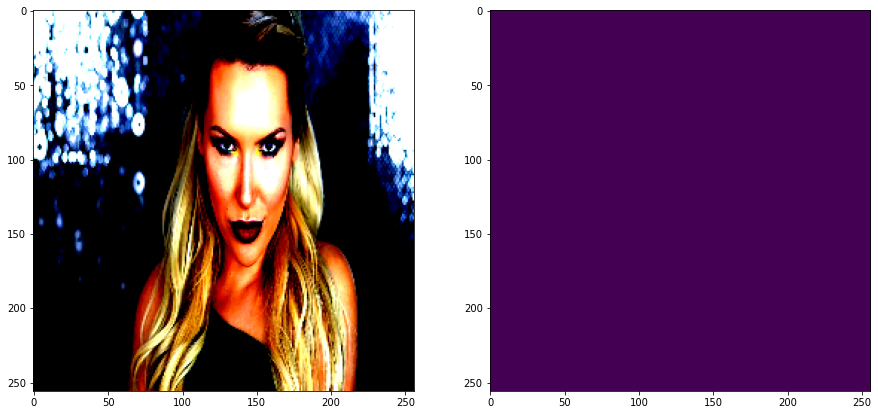

In [19]:
dataset = SelfDrivingDataset(df, preprocessing=preprocess_input)
img, masks = dataset[0]
print(img.shape, masks.shape)
fig, ax = plt.subplots(1, 2, figsize=(15, 7))
ax[0].imshow(img.permute(1, 2, 0))
ax[1].imshow(masks.permute(1, 2, 0)[..., 10])
plt.show()

In [20]:
for img, target in train_data_loader:
    print(img.shape, target.shape)
    print(img[0].min(), img[0].max())
    print(target[0].min(), target[0].max())
    break

<ipython-input-10-003d38a291c0>:47: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


torch.Size([8, 3, 256, 256]) torch.Size([8, 13, 256, 256])
tensor(0.) tensor(1.)
tensor(0, dtype=torch.uint8) tensor(1, dtype=torch.uint8)


In [21]:
from segmentation_models_pytorch import utils as smp_utils

criterion = smp.utils.losses.DiceLoss()
metrics = [smp.utils.metrics.IoU(),]

optimizer = torch.optim.Adam(params=segmodel.parameters(), lr=0.001)

In [22]:
train_epoch = smp_utils.train.TrainEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    optimizer=optimizer,
    device=device,
    verbose=True,
)

valid_epoch = smp_utils.train.ValidEpoch(
    segmodel, 
    loss=criterion, 
    metrics=metrics, 
    device=device,
    verbose=True,
)

In [23]:
# train model

max_score = 0

for i in range(0, 1):
    print(f'Epoch: {i + 1}')
    train_logs = train_epoch.run(train_data_loader)
    valid_logs = valid_epoch.run(test_data_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(segmodel, './best_model.pth')
        print('Model saved!')

Epoch: 1
train:   0%|          | 0/2502 [00:00<?, ?it/s]

<ipython-input-10-003d38a291c0>:47: DeprecationWarning: an integer is required (got type numpy.float64).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  masks = torch.as_tensor(masks, dtype=torch.uint8)


train:   1%|          | 19/2502 [04:09<9:02:42, 13.11s/it, dice_loss - 0.669, iou_score - 0.3358]


KeyboardInterrupt: ignored